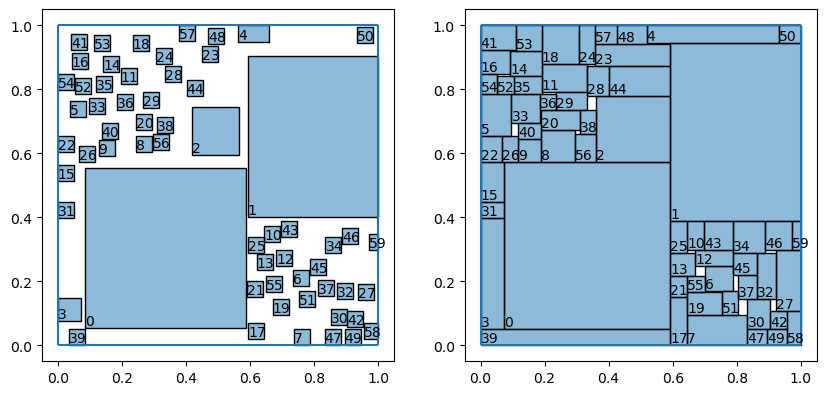

In [1]:
from SquareDivision.src.rectangle_class import Rectangulation

rects = Rectangulation(config={'seed' : 12345})# 1000000000000001})#123456})
rects.execute(num=400)
rects.prepare_constraints(keep_feasible=False)
# rects.close_holes()

rects.draw(disjoint=True, inflated=True, closed=False)

In [4]:
import numpy as np
# print(rects.sol)
# rects.report()
rects.holes_idxs

[[[48, 1], [23, 4]],
 [[13, 6], [55, 12]],
 [[6, 37], [51, 45]],
 [[55, 51], [19, 6]],
 [[51, 30], [7, 37]],
 [[25, 12], [13, 10]],
 [[34, 27], [32, 46]],
 [[30, 27], [42, 32]],
 [[29, 2], [38, 28]],
 [[5, 40], [26, 33]],
 [[8, 38], [56, 20]],
 [[11, 23], [28, 24]],
 [[35, 29], [36, 11]],
 [[16, 53], [14, 41]],
 [[54, 14], [52, 16]],
 [[33, 20], [40, 36]],
 [[52, 36], [33, 35]]]

In [2]:
rects.report(closed_Q=False)

---- AREA AND HOLES CONSTRAINTS------------------------------------------
clinch: 0.00, lower bound = 0, upper bound = 0
clinch: 0.03, lower bound = 0, upper bound = 0
clinch: 0.01, lower bound = 0, upper bound = 0
clinch: 0.00, lower bound = 0, upper bound = 0
clinch: 0.03, lower bound = 0, upper bound = 0
clinch: 0.01, lower bound = 0, upper bound = 0
clinch: 0.01, lower bound = 0, upper bound = 0
clinch: 0.02, lower bound = 0, upper bound = 0
clinch: 0.03, lower bound = 0, upper bound = 0
clinch: 0.02, lower bound = 0, upper bound = 0
clinch: 0.01, lower bound = 0, upper bound = 0
clinch: 0.01, lower bound = 0, upper bound = 0
clinch: 0.01, lower bound = 0, upper bound = 0
clinch: 0.00, lower bound = 0, upper bound = 0
clinch: 0.01, lower bound = 0, upper bound = 0
clinch: 0.00, lower bound = 0, upper bound = 0
clinch: 0.00, lower bound = 0, upper bound = 0

----INITIAL CONTACT AND BOUNDARIES---------------------------------------
clinch: 0.00, lower bound = 0.0, upper bound = 0.0
c

In [4]:
np.linalg.norm(rects.clinched_rectangles - rects.closed)**2

2.760200609327429

#### Maybe x0 from the graph ?

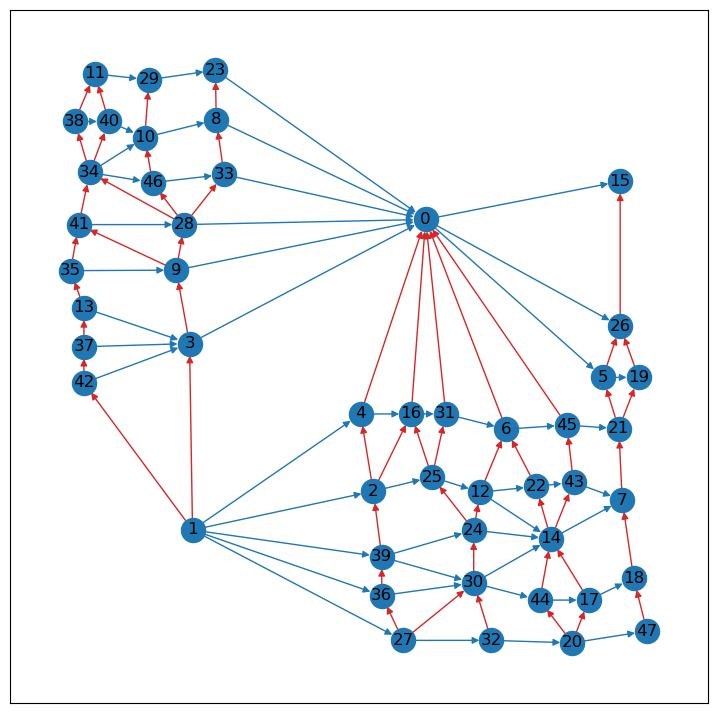

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
H = nx.from_numpy_array(rects.east_neighbours, create_using=nx.DiGraph)# + rects.north_neighbours)
V = nx.from_numpy_array(rects.north_neighbours, create_using=nx.DiGraph)# + rects.north_neighbours)
attrs = { i : {'pos': tuple(row[:2] + 0.5 * row[2:4])} for i, row in enumerate(rects.clinched_rectangles)}
nx.set_node_attributes(H, attrs)
pos = nx.get_node_attributes(H,'pos')
fig, ax = plt.subplots(figsize=(9, 9))
nx.draw_networkx(H, pos=pos, ax=ax,  edge_color='tab:blue' )
nx.draw_networkx_edges(V, pos=pos, ax=ax, edge_color='tab:red')
plt.show()

In [73]:
import numpy as np
a = np.arange(80)
a = a.reshape(-1,4)
a[[5,3,7,0]] = np.arange(16).reshape(-1,4)
a

array([[12, 13, 14, 15],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [ 4,  5,  6,  7],
       [16, 17, 18, 19],
       [ 0,  1,  2,  3],
       [24, 25, 26, 27],
       [ 8,  9, 10, 11],
       [32, 33, 34, 35],
       [36, 37, 38, 39],
       [40, 41, 42, 43],
       [44, 45, 46, 47],
       [48, 49, 50, 51],
       [52, 53, 54, 55],
       [56, 57, 58, 59],
       [60, 61, 62, 63],
       [64, 65, 66, 67],
       [68, 69, 70, 71],
       [72, 73, 74, 75],
       [76, 77, 78, 79]])

#### (w,h) Distribution playground

In [3]:
import numpy as np
pts_diag = np.array(
                 [[0.25, 0.25],
                  [0.75, 0.75]])
def tepui(
        base:float=0.05,
        top:float=0.3,
        slope:float=4,
        vertex:float=1,
        pts:np.ndarray=pts_diag
):
    return lambda pt : np.minimum(top, np.maximum(base, vertex - slope * np.min(np.linalg.norm(pts - pt, axis=1))))

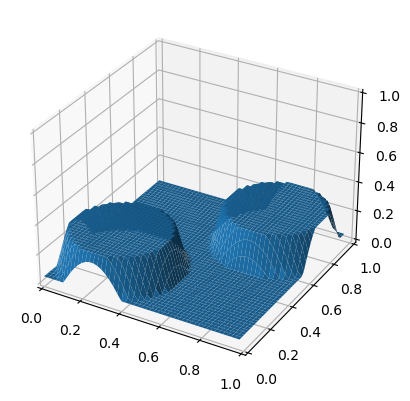

In [6]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

tepui_at = tepui(
        base=0.05,
        top=0.3,
        slope=5,
        vertex=1.5,
)

x = np.arange(0, 1, 0.02)
y = np.arange(0, 1, 0.02)

X, Y = np.meshgrid(x, y)
points = np.array([X,Y])

nu = np.apply_along_axis(tepui_at, 0, points)

fig = plt.figure()
ax:Axes = fig.add_subplot(projection='3d')
ax.axes.set_xlim3d(left=0, right=1) 
ax.axes.set_ylim3d(bottom=0, top=1) 
ax.axes.set_zlim3d(bottom=0, top=1) 
ax.plot_surface(X, Y, nu)
plt.show()

In [8]:
from SquareDivision.src.generators import uniform_pts
random_points = uniform_pts(n=5)
vals = np.apply_along_axis(tepui_at, 1, random_points)
vals
# rng = np.random.default_rng(1234)
# rng.uniform([xmin, ymin], [xmax, ymax], size=(n, 2))

array([0.4       , 0.05      , 0.05      , 0.05      , 0.36100765])

In [24]:
import numpy as np
norma_a = np.array([[1, 1],[2, 3],[4, 5],[6, 7]]).astype(float)
a=np.ones(shape=(2,2))
# recip_a = np.reciprocal(a)
# np.diagonal(norma_a.T.dot(recip_a)).sum()
# (recip_a**2)*norma_a
# norma_a[:,0] * norma_a[:,1]
type(a[1,1])

numpy.float64

In [32]:
li = [[3, 5],[2,7]]
((left, right), [down, up]) = li

In [52]:
((left, right), (down, up)) = [[1, 30], [27, 39]]
mid_pts = rects.clinched_rectangles[:,:2] + 0.5 * rects.clinched_rectangles[:,2:4]
X_lb = rects.clinched_rectangles[left, 0] + rects.clinched_rectangles[left, 2]
X_ub = rects.clinched_rectangles[right, 0]
Y_lb = rects.clinched_rectangles[down, 1] + rects.clinched_rectangles[down, 3]
Y_ub = rects.clinched_rectangles[up, 1]
# np.where(X_lb < mid_pts[0])#< X_ub)# and np.where(Y_lb<mid_pts[1]<Y_ub)
((X_lb < mid_pts[:,0])* ( mid_pts[:,0] < X_ub) * (Y_lb < mid_pts[:,1]) * (mid_pts[:,1] < Y_ub)).sum()
# mid_pts[:,0]< X_ub

1

In [19]:
import numpy as np
from numpy import linalg as LA
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint

def dist_fun(x:np.ndarray):
    return LA.norm(x-np.array([0.5, 0.5]))

# Define the constraints
def constr_fun(x:np.ndarray):
    return (x[1] - 0) * (x[1] - 1)
  
constr_0 = NonlinearConstraint(constr_fun, [0],[0])

x0 = np.array([0.5, 0.5])

res = minimize(dist_fun, x0, constraints=[constr_0], method='SLSQP')

optimal_params = res.x
optimal_value = res.fun

In [14]:
import numpy as np
from numpy import linalg as LA
from scipy.optimize import fsolve, NonlinearConstraint

def dist_fun(x:np.ndarray, y:np.ndarray):
    return LA.norm(x-y)

def system(x:np.ndarray):
    return [dist_fun(x , np.array([1,0,0]))-2,
            dist_fun(x , np.array([0,0,0]))-1,
            dist_fun(x , np.array([-1,0,0]))-2
            ]
root = fsolve(system, x0=[0, 1, 0.2], full_output=True)
root[-2] == 1

True

In [12]:
import numpy as np
x=np.arange(12).reshape(-1,4).shape
# x.dot(x)
type(np.prod(tuple(x)))

numpy.int32

In [10]:
import numpy as np
a = (2.3, 2.3)
np.argmin(a)

0